In [1]:
import numpy as np
import os
import configparser

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plotn
from keras.optimizers import SGD

from keras import models

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, './lib/')
from help_functions import *

from lib.model_lib import *
#function to obtain data for training/testing (validation)
from extract_patches import get_data_training
from extract_patches import get_combine_data_training

print(K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

['/job:localhost/replica:0/task:0/device:GPU:0']


## custom U-net Model

### Load Configuration

In [2]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
save_folder = config.get('experiment name','result_save_path')
save_folder = 'result/'+save_folder
name_experiment = config.get('experiment name', 'name')

#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

In [3]:
train_lists = []
label_lists = []
ratio_lists = [0.4,0.3,0.3]

DRIVE_train_imgs_original = config.get('data paths','DRIVE_train_imgs_original')
DRIVE_train_groundTruth = config.get('data paths','DRIVE_train_groundTruth')
train_lists.append(path_data+DRIVE_train_imgs_original)
label_lists.append(path_data+DRIVE_train_groundTruth)


#STARE
STARE_train_imgs_original = config.get('data paths','STARE_train_imgs_original')
STARE_train_groundTruth = config.get('data paths','STARE_train_groundTruth')
train_lists.append(path_data+STARE_train_imgs_original)
label_lists.append(path_data+STARE_train_groundTruth)


#CHASE
CHASE_train_imgs_original = config.get('data paths','CHASE_train_imgs_original')
CHASE_train_groundTruth = config.get('data paths','CHASE_train_groundTruth')
train_lists.append(path_data+CHASE_train_imgs_original)
label_lists.append(path_data+CHASE_train_groundTruth)

#HRF
HRF_train_imgs_original = config.get('data paths','HRF_train_imgs_original')
HRF_train_groundTruth = config.get('data paths','HRF_train_groundTruth')

#train_lists.append(path_data+HRF_train_imgs_original)
#label_lists.append(path_data+HRF_train_groundTruth)

#Fixed CONJ
CONJ_train_imgs_original = config.get('data paths','CONJ_train_imgs_original')
CONJ_train_groundTruth = config.get('data paths','CONJ_train_groundTruth')

In [4]:
print(name_experiment)
print(train_lists)
print(len(train_lists))

temp = train_lists[0].split('/')
print(temp[2])

print(label_lists[0].split('/'))

figure5_augReduceLr_conjHrf
['./hdf5_datasets_training_testing/DRIVE/DRIVE_dataset_imgs_train.hdf5', './hdf5_datasets_training_testing/STARE/STARE_dataset_imgs_train.hdf5', './hdf5_datasets_training_testing/CHASE_DB/CHASE_dataset_imgs_train.hdf5']
3
DRIVE
['.', 'hdf5_datasets_training_testing', 'DRIVE', 'DRIVE_dataset_groundTruth_train.hdf5']


In [3]:
if os.path.isdir('./'+save_folder+'/'+name_experiment) == False:
    os.mkdir('./'+save_folder+'/'+name_experiment)
else:
    print('already exist the folder in this path : {}'.format('./'+save_folder+'/'+name_experiment))

already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf


In [5]:
DB_patches, key_train, key_label = get_combine_data_training(
    list_train_imgs_original = train_lists, 
    list_train_groudTruth = label_lists,  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    patch_ratio_list = ratio_lists,
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment
)

NameError: name 'train_lists' is not defined

In [ ]:
print(DB_patches.keys())
print(key_train)
print(key_label)
print(np.shape(DB_patches['DRIVE_train']))
print(np.shape(DB_patches['DRIVE_label']))
print(np.shape(DB_patches['STARE_train']))
print(np.shape(DB_patches['STARE_label']))
print(np.shape(DB_patches['CHASE_DB_train']))
print(np.shape(DB_patches['CHASE_DB_label']))

patches_imgs_train = np.concatenate((DB_patches['DRIVE_train'], DB_patches['STARE_train']),axis = 0)
patches_imgs_train = np.concatenate((patches_imgs_train, DB_patches['CHASE_DB_train']),axis = 0)

patches_masks_train = np.concatenate((DB_patches['DRIVE_label'], DB_patches['STARE_label']),axis = 0)
patches_masks_train = np.concatenate((patches_masks_train, DB_patches['CHASE_DB_label']),axis = 0)

print(np.shape(patches_imgs_train))
print(np.shape(patches_masks_train))

### Extract patch for training

In [4]:
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + config.get('data paths', 'CONJ_train_imgs_original'),
    DRIVE_train_groudTruth = path_data + config.get('data paths', 'CONJ_train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment)

already exist the folder in this path : result/figure5/figure5_aug400000_batch16_lr_conjHrf
number of subimages :  400000
[DEBUG] shape of train_imgs_original :  (25, 3, 900, 1100)
[DEBUG] shape of train_imgs_label :  (25, 1, 900, 1100)
[DEBUG] normalize shape :  (25, 1, 900, 1100)
[DEBUG] i normalize shape :  (1, 900, 1100)
[get_data_training] preprocessed image shape :  (25, 1, 900, 1100)
train image max :  1.0 train image min :  0.0
255.0
[get_data_training] preprocessed2 image shape :  (25, 1, 900, 1100)
1.0

[get_data_training] train images/masks shape : (25, 1, 900, 1100)
[get_data_training] train images range (min-max) [0.0 , 1.0] 
[get_data_training] train masks are within 0-1

Maximum subsample size :  866096
[extract random] patches shape : (400000, 1, 64, 64)
[extract random] patches per full image : 16000
aug patch shape : (64, 64, 1) aug mask shape : (64, 64, 1)
aug patch shape : (64, 64, 1) aug mask shape : (64, 64, 1)
aug patch shape : (64, 64, 1) aug mask shape : (64, 6

In [5]:
print(np.shape(patches_imgs_train))
print(np.max(patches_imgs_train[1]))
print(len(patches_imgs_train))
print(np.max(patches_masks_train))


(400000, 1, 64, 64)
0.4188419117647059
400000
1.0


### Visualizing

[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7F5D52162160>
file name :  ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/sample_input_imgs
[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7F5D52162208>
file name :  ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/sample_input_masks


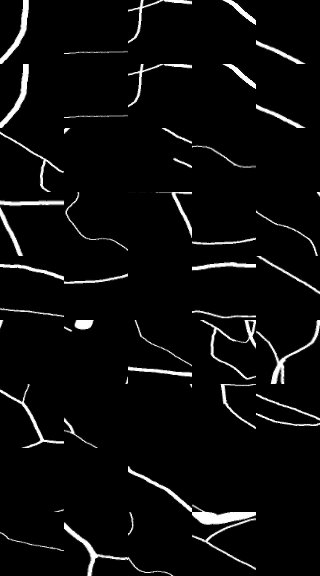

In [6]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:]* 255,5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:] * 255,5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks")#.show()

### Data gen test

### Model fitting

In [7]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]


#model = naive_attn_unet(n_ch, patch_height, patch_width)  #the U-net model
#model = unet(n_ch, patch_height, patch_width)
model = attn_unet(n_ch, patch_height, patch_width,2)
#model = small_attn_unet(n_ch, patch_height, patch_width,2)
print ("Check: final output of the network:")
print (model.output_shape)

plot(model, to_file= './'+save_folder+'/'+name_experiment+'/' +name_experiment+ '_model.png')   #check how the model looks like
#plot(model, to_file= name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+save_folder+'/'+name_experiment+'/' +name_experiment+'_architecture.json', 'w').write(json_string)


input shape :  (None, 1, 64, 64)

gating shape : (None, 128, 4, 4), conv4 shape : (None, 64, 8, 8)
shape x,g  (None, 64, 8, 8) (None, 128, 4, 4)
inter shape :   128
stride x : 1 stride y : 1
theta_x shape :  (None, 128, 4, 4)
upsample_g shape :  (None, 128, 4, 4)

attn1 shape : (None, 64, 8, 8) center shape : (None, 128, 4, 4) 

attn1 shape : (None, 64, 8, 8) up1 shape : (None, 128, 8, 8)
shape x,g  (None, 64, 16, 16) (None, 128, 8, 8)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 8, 8)
upsample_g shape :  (None, 64, 8, 8)
shape x,g  (None, 32, 32, 32) (None, 128, 16, 16)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 16, 16)
upsample_g shape :  (None, 64, 16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64)    0                      

41700

In [8]:
from keras.callbacks import Callback
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import math


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1)

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # 1e-9 + (1e-6 ) * (1 + cos ())
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
    

In [9]:
print(int(config.get('training settings', 'num_subimgs')))

400000


### Training Session

In [10]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption

#patches_masks_train = masks_Unet(temp_label)
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)

#history = model.fit(temp_img, temp_label, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])


history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer, reduce_lr , early_stopping])
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)


[training session] before mask unet func patch mask shape :  (400000, 1, 64, 64)
[training session] after mask unet func patch mask shape :  (400000, 4096, 2)
Train on 320000 samples, validate on 80000 samples
Epoch 1/150
320000/320000 [==============================] - 1565s 5ms/step - loss: 0.1153 - dice_coef: 0.8847 - val_loss: 0.0756 - val_dice_coef: 0.9244

Epoch 00001: val_loss improved from inf to 0.07558, saving model to ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/best_weights.h5
Epoch 2/150
320000/320000 [==============================] - 1752s 5ms/step - loss: 0.0674 - dice_coef: 0.9326 - val_loss: 0.0629 - val_dice_coef: 0.9371

Epoch 00002: val_loss improved from 0.07558 to 0.06287, saving model to ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/best_weights.h5
Epoch 3/150
320000/320000 [==============================] - 1703s 5ms/step - loss: 0.0578 - dice_coef: 0.9422 - val_loss: 0.0577 - val_dice_coef: 0.9423

Epoch 00003: val_loss improved from 0.06287 t

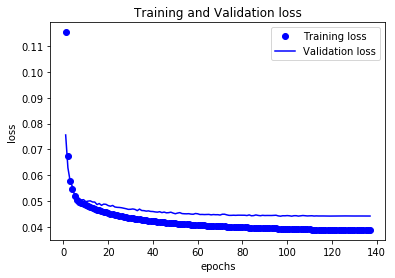

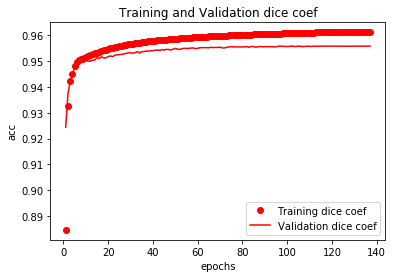

already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history
already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history
already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history


In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training dice coef")
plt.plot(epochs, val_acc, 'r', label = "Validation dice coef")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()

import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

In [12]:
import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history
already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history
already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history
already exist the folder in this path : ./result/figure5/figure5_aug400000_batch16_lr_conjHrf/train_history


## 